# Regression on Boston House Prices dataset using the new kernel

In [17]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import plot_matrix, get_lower_triangular_from_diag
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


Load Boston dataset

In [18]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std
D = X_train.shape[1]
#X_train = X_train[:,0:D]

Visualize the correlation matrix

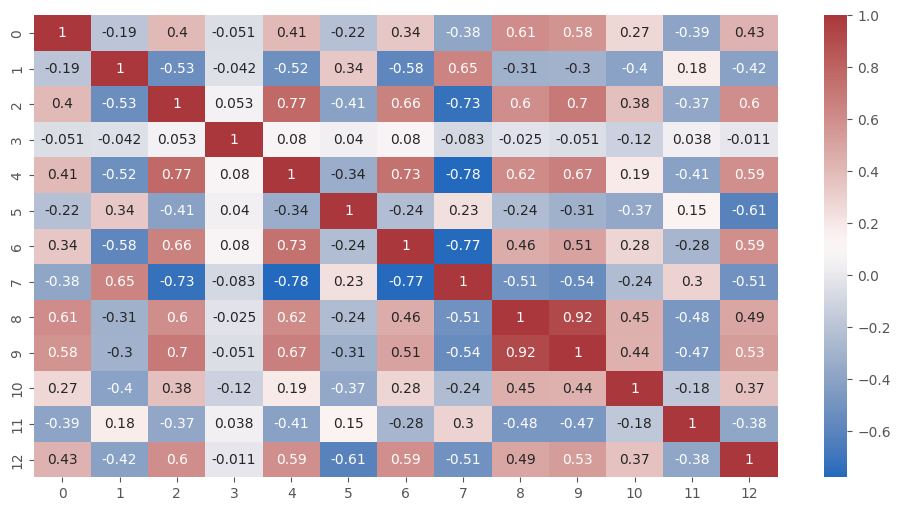

In [19]:
plot_matrix(X_train, correlation=True)

Show that the Lambda RBF kernel is equivalent in the computation of the kernel matrix

In [20]:
D=13
# Define the lengthscales according to the RBF kernel standard
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
# Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
Lambda_L = get_lower_triangular_from_diag(lengthscales)
# Convert it into the triangular representation
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)

LRBF = LambdaRBF(Lambda_L_array, 1.0)
lrbf = LRBF.K(X_train)[5,3]

# Standard RBF kernel
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
rbf = RBF.K(X_train)[5,3]
print('LambdaRBF val: ', lrbf)
print('RBF val: ',rbf)

LambdaRBF val:  tf.Tensor(2.1873073773137628e-94, shape=(), dtype=float64)
RBF val:  tf.Tensor(2.1873073773077947e-94, shape=(), dtype=float64)


Obtain the LRBF for a generic matrix (not diagonal)

In [21]:
D = 13
ts = gpflow.utilities.bijectors.triangular_size(D)
# Define an array that represents the entire L matrix
Lambda_L_array_full = tf.constant([D**0.5]*ts, dtype=tf.float64)

LRBF = LambdaRBF(Lambda_L_array_full, 1.0)
LRBF.K(X_train)[5,3]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

## Compare the RBF kernel with LambdaRBF with equivalent starting lengthscales

### LambdaRBF kernel

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[0.07692308 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.07692308 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.07692308 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.07692308 0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.07692308 0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.      

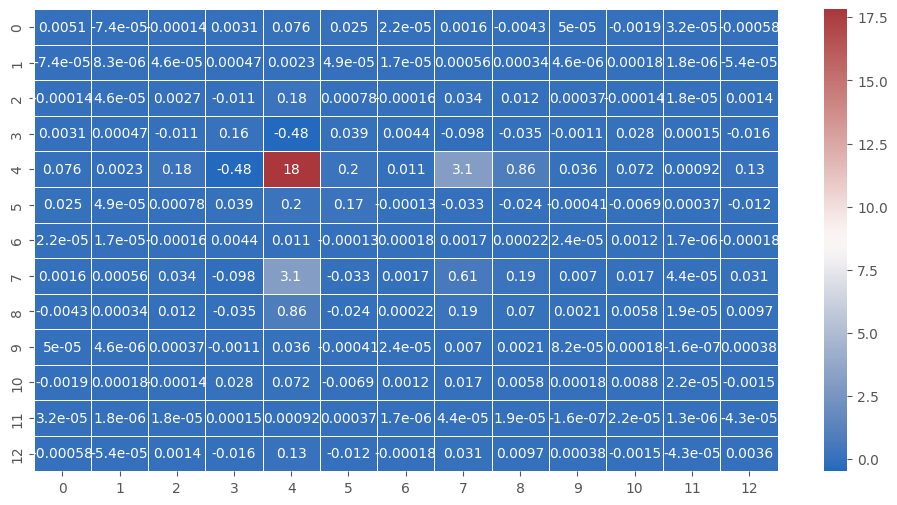

In [22]:
D = 13
# Define the kernel and put a Normal prior
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L, 1.0)
LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))

# GPR model (no approx)
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('Intial value of kernel variance: ', LRBF.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LRBF.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Initial LML: ',model_LRBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', LRBF.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LRBF.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Final LML: ',model_LRBF.log_marginal_likelihood())
plot_matrix(tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))

In [23]:
y_pred_train, _ = model_LRBF.predict_f(X_train)
train_rmse_stan = tf.sqrt(tf.reduce_mean((Y_train - y_pred_train)**2)).numpy()
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
y_pred_test, _ = model_LRBF.predict_f(X_test)
test_rmse_stan = tf.sqrt(tf.reduce_mean((Y_test - y_pred_test)**2)).numpy()
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.136
Test RMSE (Standardised): 0.383


### RBF kernel (standard)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128])>
Initial LML:  tf.Tensor(-596.9581932967583, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7690938309513308>
Optimal value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.84702933, 1.00032045, 1.00033834, 2.04538162, 0.31640921,
       1.94130894, 6.37579123, 2.23841261, 1.00070111, 0.99877259,
       1.00036933, 6.45505217, 5.09841146])>
Final LML:  tf.Tensor(-483.3437548093102, shape=(), dtype=float64)


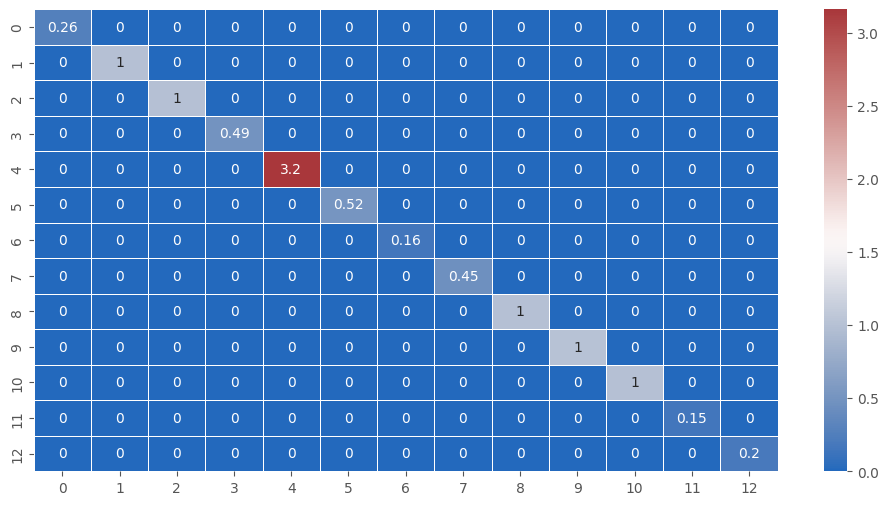

In [24]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), 
                                                   scale=gpflow.utilities.to_default_float(1.))
k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), 
                                               scale=gpflow.utilities.to_default_float(1.))
model_RBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=k,
)
gpflow.utilities.print_summary(model_RBF, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', k.lengthscales)
print('Initial LML: ',model_RBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_RBF.training_loss, model_RBF.trainable_variables)
Lambda_diag = tf.linalg.inv(tf.linalg.diag(k.lengthscales))
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', k.lengthscales)
print('Final LML: ', model_RBF.log_marginal_likelihood())
plot_matrix(Lambda_diag)

In [25]:
y_pred_train, _ = model_RBF.predict_f(X_train)
train_rmse_stan = tf.sqrt(tf.reduce_mean((Y_train - y_pred_train)**2)).numpy()
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
y_pred_test, _ = model_RBF.predict_f(X_test)
test_rmse_stan = tf.sqrt(tf.reduce_mean((Y_test - y_pred_test)**2)).numpy()
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.044
Test RMSE (Standardised): 0.762


## LambdaRBF kernel with full L starting matrix

Instead of initializing the $\Lambda$ matrix as: $$\Lambda=diag(lengthscales)$$ we set directly the lower triangular $L$ as: $$L=\sqrt{D}\cdot\mathcal{I}_D$$

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[ 13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.]
 [ 13.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.]
 [ 13.  26.  39.  39.  39.  39.  39.  39.  39.  39.  39.  39.  39.]
 [ 13.  26.  39.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.]
 [ 13.  26.  39.  52.  65.  65.  65.  65.  65.  65.  65.  65.  65.]
 [ 13.  26.  39.  52.  65.  78.  78.  78.  78.  78.  78.  78.  78.]
 [ 13.  26.  39.  52.  65.  78.  91.  91.  91.  91.  91.  91.  91.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 104. 104. 104. 104. 104.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 117. 117. 117. 117. 117.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 130. 130. 130.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 143. 143.]
 [ 13.  26.  39.  52.  65.  78.  91. 104. 117. 130. 143. 156. 156.]
 [ 13.  26.  39.  52.  65.  

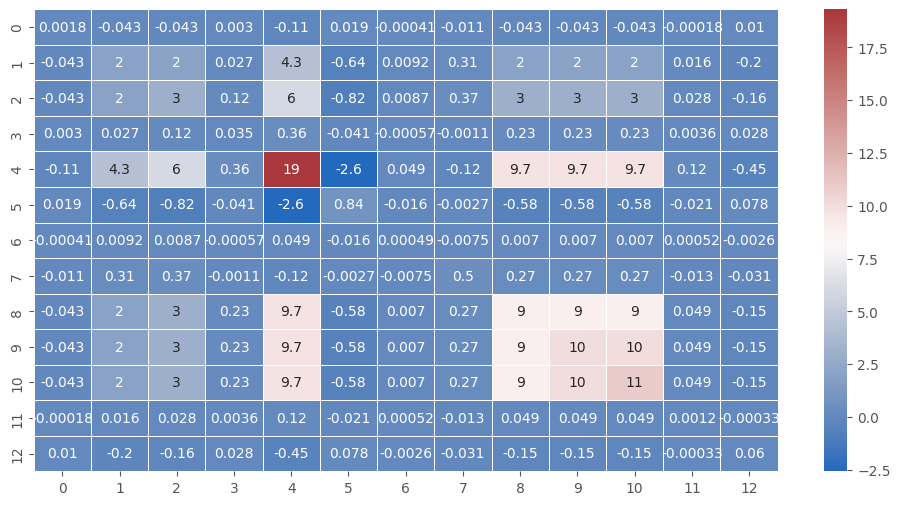

In [26]:
D = 13

# Define the kernel and put a Normal prior
ts = gpflow.utilities.bijectors.triangular_size(D)
Lambda_L_array_full = tf.constant([D**0.5]*ts, dtype=tf.float64)
LRBF = LambdaRBF(Lambda_L_array_full, 1.0)
LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))

# GPR model (no approx)
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('Intial value of kernel variance: ', LRBF.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LRBF.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Initial LML: ',model_LRBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', LRBF.variance)
Lambda_L_matrix = tfp.math.fill_triangular(LRBF.Lambda_L)
print('Initial value of Lambda: ', tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))
print('Final LML: ',model_LRBF.log_marginal_likelihood())
plot_matrix(tf.linalg.matmul(Lambda_L_matrix, tf.transpose(Lambda_L_matrix)))

In [27]:
y_pred_train, _ = model_LRBF.predict_f(X_train)
train_rmse_stan = tf.sqrt(tf.reduce_mean((Y_train - y_pred_train)**2)).numpy()
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
y_pred_test, _ = model_LRBF.predict_f(X_test)
test_rmse_stan = tf.sqrt(tf.reduce_mean((Y_test - y_pred_test)**2)).numpy()
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.000
Test RMSE (Standardised): 0.603
